# Data source

In [1]:
# Data source:
# Open Power System Data – Time Series dataset
# URL: https://data.open-power-system-data.org/time_series/

In [2]:
import pandas as pd
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')  # Use a more professional chart style
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data overview

## 1. Load data 

In [3]:
data = pd.read_csv("time_series_15min_singleindex.csv")
wind_df = data[["utc_timestamp", "DE_wind_generation_actual"]].copy()

## 2. Convert timestamp and set as index

In [4]:
wind_df["utc_timestamp"] = pd.to_datetime(wind_df["utc_timestamp"])
wind_df.set_index("utc_timestamp", inplace=True)
wind_df.index.name = "timestamp"  # Give the index a clear name

## 3. Print key overview information

In [5]:
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Original Data Shape: {wind_df.shape}")
print(f"Time Range: {wind_df.index.min()} to {wind_df.index.max()}")
print(f"Inferred Frequency: {wind_df.index.inferred_freq or 'Possibly Irregular'}")
print(f"Total Days: {(wind_df.index.max() - wind_df.index.min()).days} days")
print(f"Expected Data Points (15-min interval): {((wind_df.index.max() - wind_df.index.min()).days * 24 * 4)}")
print(f"Actual Data Points: {len(wind_df)}")
print(f"Data Completeness: {len(wind_df) / ((wind_df.index.max() - wind_df.index.min()).days * 24 * 4):.2%}")

DATASET OVERVIEW
Original Data Shape: (201604, 1)
Time Range: 2014-12-31 23:00:00+00:00 to 2020-09-30 23:45:00+00:00
Inferred Frequency: 15min
Total Days: 2100 days
Expected Data Points (15-min interval): 201600
Actual Data Points: 201604
Data Completeness: 100.00%


In [6]:
print("\n" + "=" * 60)
print("FIRST 5 ROWS OF DATA:")
print("=" * 60)
print(wind_df.head())

print("\n" + "=" * 60)
print("DATA INFO:")
print("=" * 60)
print(wind_df.info())

print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS:")
print("=" * 60)
print(wind_df.describe())


FIRST 5 ROWS OF DATA:
                           DE_wind_generation_actual
timestamp                                           
2014-12-31 23:00:00+00:00                        NaN
2014-12-31 23:15:00+00:00                        NaN
2014-12-31 23:30:00+00:00                        NaN
2014-12-31 23:45:00+00:00                        NaN
2015-01-01 00:00:00+00:00                        NaN

DATA INFO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201604 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:45:00+00:00
Data columns (total 1 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   DE_wind_generation_actual  201300 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB
None

DESCRIPTIVE STATISTICS:
       DE_wind_generation_actual
count              201300.000000
mean                11552.324213
std                  9080.676730
min                   104.660000
25%                  4504.955000

# Handle missing value

## 1. Record the original missing data situation

In [7]:
original_missing = wind_df["DE_wind_generation_actual"].isna().sum()
print(f"Original Missing Values Count: {original_missing} ({original_missing/len(wind_df):.2%})")

Original Missing Values Count: 304 (0.15%)


In [8]:
missing = wind_df["DE_wind_generation_actual"].isna()
missing_dates = wind_df.index[missing]

daily_missing = missing.groupby(missing.index.date).sum()
missing_days = daily_missing[daily_missing > 0]
print(missing_days)

2014-12-31     4
2015-01-01     1
2016-05-31    12
2016-06-01    84
2016-10-27     8
2016-10-28    88
2016-11-03    10
2016-12-08     4
2016-12-09    92
2020-09-30     1
Name: DE_wind_generation_actual, dtype: int64


## 2. Fill missing values

In [9]:
# Step 1: Define small gaps threshold
small_gap_threshold = 12  # number of missing time steps considered as a 'small gap'

# Step 2: Identify days with small gaps
# 'daily_missing' contains the number of missing time steps per day
small_gap_days = daily_missing[daily_missing <= small_gap_threshold].index

# Step 3: Forward-fill missing values for small gaps
# For each day with a small number of missing points, fill missing values using previous valid value
for day in small_gap_days:
    mask = wind_df.index.date == day
    wind_df.loc[mask, "DE_wind_generation_actual"] = wind_df.loc[mask, "DE_wind_generation_actual"].ffill()

# Step 4: Forward-fill remaining missing values
wind_df["DE_wind_generation_actual"] = wind_df["DE_wind_generation_actual"].ffill()

# Step 5: Backward-fill any remaining missing values
# This handles missing values at the start of the series (e.g., the first record)
wind_df["DE_wind_generation_actual"] = wind_df["DE_wind_generation_actual"].bfill()

In [10]:
wind_df.isna().sum()

DE_wind_generation_actual    0
dtype: int64

# Identify trends and patterns

## 1. Global trends and patterns

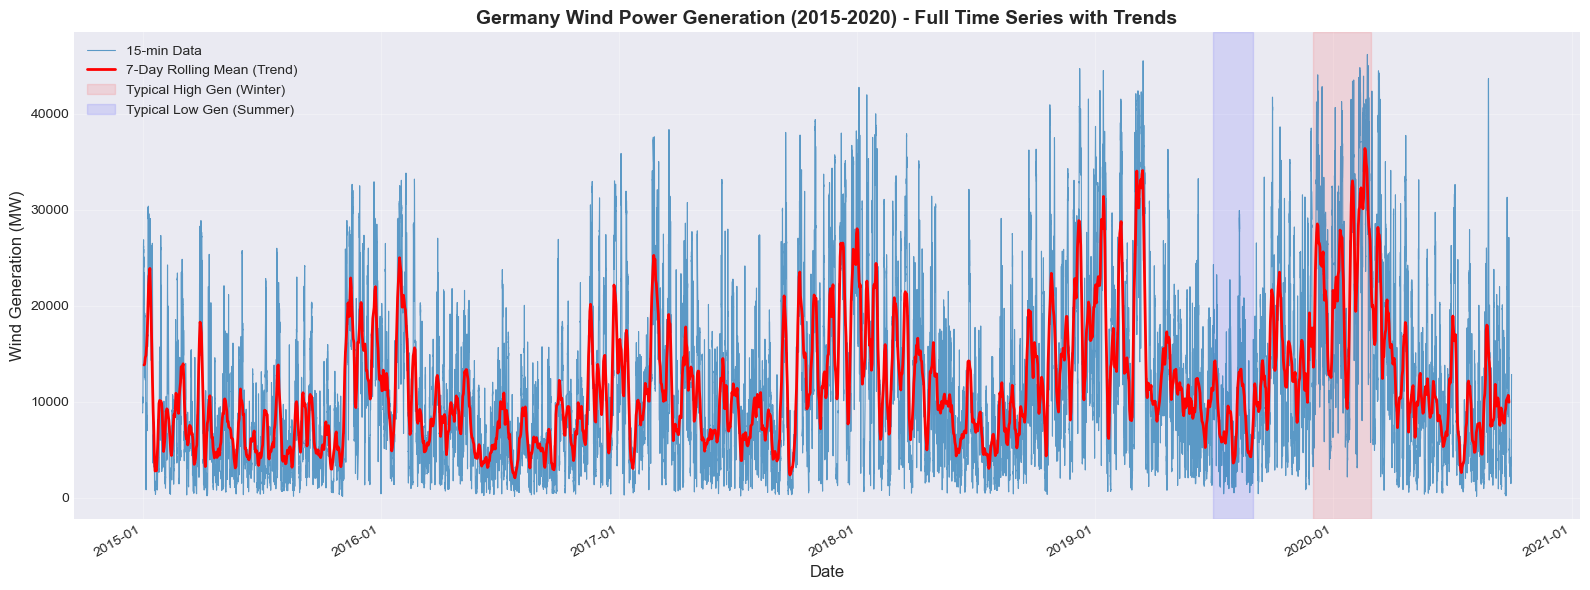

In [11]:
plt.figure(figsize=(16, 6))

# Plot the full time series
plt.plot(wind_df.index, wind_df["DE_wind_generation_actual"], 
         color='tab:blue', alpha=0.7, linewidth=0.8, label='15-min Data')

# Add a rolling average to highlight the trend (7-day window, daily resampled for efficiency)
# First, resample to daily to speed up the rolling calculation if needed
daily_series = wind_df["DE_wind_generation_actual"].resample('D').mean()
rolling_avg = daily_series.rolling(window=7, center=True).mean()

# Plot the rolling average (trend line)
plt.plot(rolling_avg.index, rolling_avg.values, 
         color='red', linewidth=2, label='7-Day Rolling Mean (Trend)')

# Highlight key periods for discussion (e.g., winter peaks, summer troughs)
# Add shaded regions for typical high/low generation seasons
plt.axvspan(pd.Timestamp('2019-12-01'), pd.Timestamp('2020-02-28'), 
            alpha=0.1, color='red', label='Typical High Gen (Winter)')
plt.axvspan(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-08-31'), 
            alpha=0.1, color='blue', label='Typical Low Gen (Summer)')

plt.xlabel("Date", fontsize=12)
plt.ylabel("Wind Generation (MW)", fontsize=12)
plt.title("Germany Wind Power Generation (2015-2020) - Full Time Series with Trends", 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Improve x-axis ticks for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()  # Auto-format dates

plt.tight_layout()
plt.show()

In [12]:
# ============================================================================
# DATA INSIGHTS FROM GLOBAL VIEW
# ============================================================================
print("=" * 70)
print("KEY INSIGHTS FROM FULL TIME SERIES ANALYSIS")
print("=" * 70)

# 1. Calculate basic statistics
print("\n1. OVERALL STATISTICS:")
print(f"   • Total Period: {wind_df.index.min().date()} to {wind_df.index.max().date()}")
print(f"   • Average Generation: {wind_df['DE_wind_generation_actual'].mean():.0f} MW")
print(f"   • Maximum Generation: {wind_df['DE_wind_generation_actual'].max():.0f} MW")
print(f"   • Minimum Generation: {wind_df['DE_wind_generation_actual'].min():.0f} MW")

# 2. Identify seasonal pattern
print("\n2. SEASONAL PATTERN IDENTIFICATION:")
# Calculate monthly averages across all years
wind_df['month'] = wind_df.index.month
monthly_avg = wind_df.groupby('month')['DE_wind_generation_actual'].mean()

# Find top 3 and bottom 3 months
top_months = monthly_avg.nlargest(3)
bottom_months = monthly_avg.nsmallest(3)

print(f"   • Highest Generation Months: {', '.join([f'{i} ({v:.0f} MW)' for i, v in top_months.items()])}")
print(f"   • Lowest Generation Months: {', '.join([f'{i} ({v:.0f} MW)' for i, v in bottom_months.items()])}")

# 3. Check for growth trend
print("\n3. YEAR-OVER-YEAR TREND:")
annual_totals = wind_df['DE_wind_generation_actual'].resample('YE').sum()
growth_rates = annual_totals.pct_change() * 100

for year, growth in zip(annual_totals.index[1:], growth_rates.dropna()):
    print(f"   • {year.year}: {growth:+.1f}% change from previous year")

print("\n" + "=" * 70)

KEY INSIGHTS FROM FULL TIME SERIES ANALYSIS

1. OVERALL STATISTICS:
   • Total Period: 2014-12-31 to 2020-09-30
   • Average Generation: 11554 MW
   • Maximum Generation: 46206 MW
   • Minimum Generation: 105 MW

2. SEASONAL PATTERN IDENTIFICATION:
   • Highest Generation Months: 12 (17528 MW), 1 (16029 MW), 2 (15656 MW)
   • Lowest Generation Months: 8 (7340 MW), 7 (7608 MW), 6 (7689 MW)

3. YEAR-OVER-YEAR TREND:
   • 2015: +875017.6% change from previous year
   • 2016: -0.4% change from previous year
   • 2017: +33.6% change from previous year
   • 2018: +5.7% change from previous year
   • 2019: +14.0% change from previous year
   • 2020: -24.7% change from previous year



## 2. Additional trends and insights

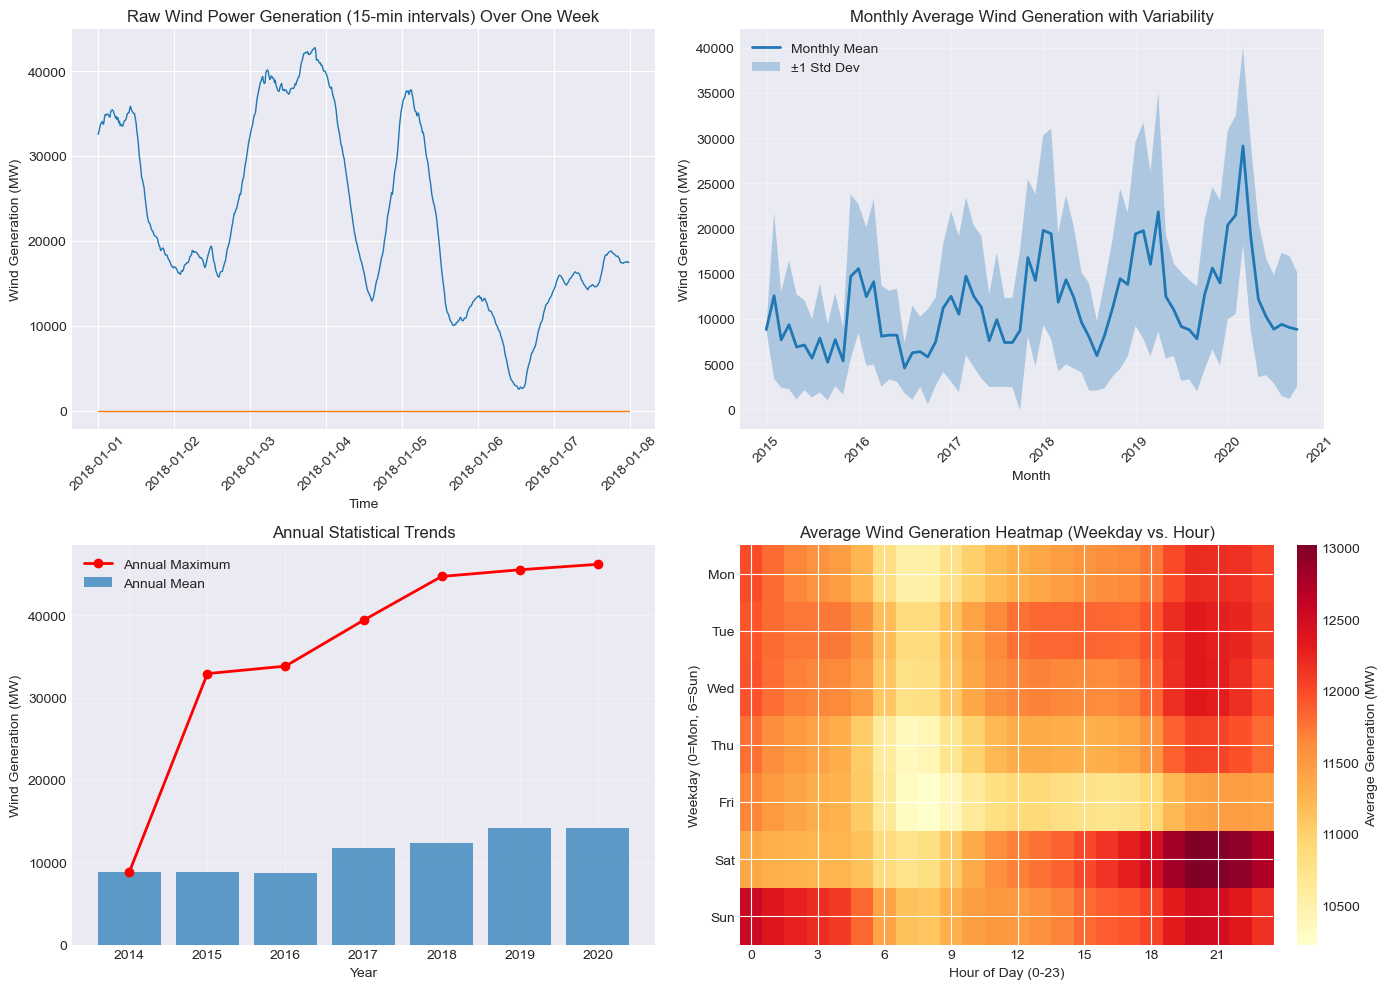

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Raw Data Segment (One Week) - Stays the same
axes[0, 0].plot(wind_df["2018-01-01":"2018-01-07"], label='15-minute Data', linewidth=1)
axes[0, 0].set_title('Raw Wind Power Generation (15-min intervals) Over One Week')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Wind Generation (MW)')
#axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Calculate monthly averages to show seasonal pattern
monthly_avg = wind_df["DE_wind_generation_actual"].resample('ME').mean()
monthly_std = wind_df["DE_wind_generation_actual"].resample('ME').std()

axes[0, 1].plot(monthly_avg.index, monthly_avg.values, label='Monthly Mean', linewidth=2)
axes[0, 1].fill_between(monthly_avg.index, 
                        monthly_avg - monthly_std, 
                        monthly_avg + monthly_std, 
                        alpha=0.3, label='±1 Std Dev')
axes[0, 1].set_title('Monthly Average Wind Generation with Variability')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Wind Generation (MW)')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Annual Summary Statistics - Stays the same (Shows year-over-year trend)
annual_mean = wind_df["DE_wind_generation_actual"].resample('YE').mean()
annual_max = wind_df["DE_wind_generation_actual"].resample('YE').max()
axes[1, 0].bar(range(len(annual_mean)), annual_mean.values, label='Annual Mean', alpha=0.7)
axes[1, 0].plot(range(len(annual_max)), annual_max.values, 'r-o', label='Annual Maximum', linewidth=2)
axes[1, 0].set_title('Annual Statistical Trends')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Wind Generation (MW)')
axes[1, 0].set_xticks(range(len(annual_mean)))
axes[1, 0].set_xticklabels([str(year.year) for year in annual_mean.index])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. REPLACED: Daily Profile Heatmap (More insightful than completeness)
# Calculate average generation by hour and weekday
wind_df['hour'] = wind_df.index.hour
wind_df['weekday'] = wind_df.index.weekday  # Monday=0, Sunday=6
daily_profile = wind_df.groupby(['weekday', 'hour'])['DE_wind_generation_actual'].mean().unstack()

im = axes[1, 1].imshow(daily_profile, aspect='auto', cmap='YlOrRd')
axes[1, 1].set_title('Average Wind Generation Heatmap (Weekday vs. Hour)')
axes[1, 1].set_xlabel('Hour of Day (0-23)')
axes[1, 1].set_ylabel('Weekday (0=Mon, 6=Sun)')
axes[1, 1].set_xticks(range(0, 24, 3))
axes[1, 1].set_yticks(range(7))
axes[1, 1].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Add a colorbar for the heatmap
cbar = plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)
cbar.set_label('Average Generation (MW)')

plt.tight_layout()
plt.show()

In [14]:
# Additional Insight: Print the weekly pattern you observed
print("\n" + "=" * 60)
print("WEEKLY PATTERN ANALYSIS (Based on visual observation)")
print("=" * 60)
print("• Weeks 1-11: High generation (Winter/early Spring)")
print("• Week 29: Lowest generation (Summer - July)")
print("• Weeks 49-53: Peak generation again (Winter)")
print("\nThis clear annual cycle justifies our focus on yearly seasonality.")


WEEKLY PATTERN ANALYSIS (Based on visual observation)
• Weeks 1-11: High generation (Winter/early Spring)
• Week 29: Lowest generation (Summer - July)
• Weeks 49-53: Peak generation again (Winter)

This clear annual cycle justifies our focus on yearly seasonality.


## 3. Monthly seasonality analysis

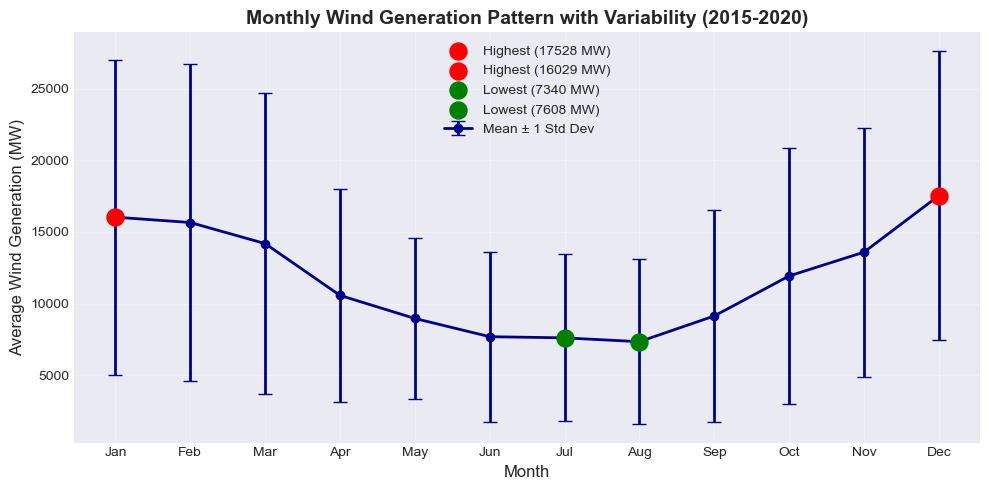

In [15]:
wind_df['month'] = wind_df.index.month

# Calculate monthly statistics (not just mean)
monthly_stats = wind_df.groupby('month')["DE_wind_generation_actual"].agg(['mean', 'std', 'min', 'max'])
monthly_avg = monthly_stats['mean']
monthly_std = monthly_stats['std']

plt.figure(figsize=(10, 5))

# Plot mean with error bars (showing variability)
plt.errorbar(monthly_avg.index, monthly_avg.values, 
             yerr=monthly_std.values, fmt='-o', 
             color='darkblue', linewidth=2, capsize=5, label='Mean ± 1 Std Dev')

# Highlight key months
highlight_months = {
    'Highest': monthly_avg.nlargest(2).index.tolist(),
    'Lowest': monthly_avg.nsmallest(2).index.tolist()
}

colors = {'Highest': 'red', 'Lowest': 'green'}
for label, months in highlight_months.items():
    for month in months:
        plt.scatter(month, monthly_avg[month], 
                   color=colors[label], s=150, zorder=5, 
                   label=f'{label} ({monthly_avg[month]:.0f} MW)')

plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Wind Generation (MW)", fontsize=12)
plt.title("Monthly Wind Generation Pattern with Variability (2015-2020)", 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()

In [16]:
# Print key insights
print("=" * 60)
print("MONTHLY PATTERN INSIGHTS")
print("=" * 60)
print(f"• Peak Generation: Month {monthly_avg.idxmax()} ({monthly_avg.max():.0f} MW)")
print(f"• Lowest Generation: Month {monthly_avg.idxmin()} ({monthly_avg.min():.0f} MW)")
print(f"• Seasonal Range: {monthly_avg.max() - monthly_avg.min():.0f} MW")
print(f"• Winter Avg (Dec-Feb): {monthly_avg.loc[[12,1,2]].mean():.0f} MW")
print(f"• Summer Avg (Jun-Aug): {monthly_avg.loc[[6,7,8]].mean():.0f} MW")

MONTHLY PATTERN INSIGHTS
• Peak Generation: Month 12 (17528 MW)
• Lowest Generation: Month 8 (7340 MW)
• Seasonal Range: 10188 MW
• Winter Avg (Dec-Feb): 16404 MW
• Summer Avg (Jun-Aug): 7545 MW


## 4. Weekly seasonality analysis

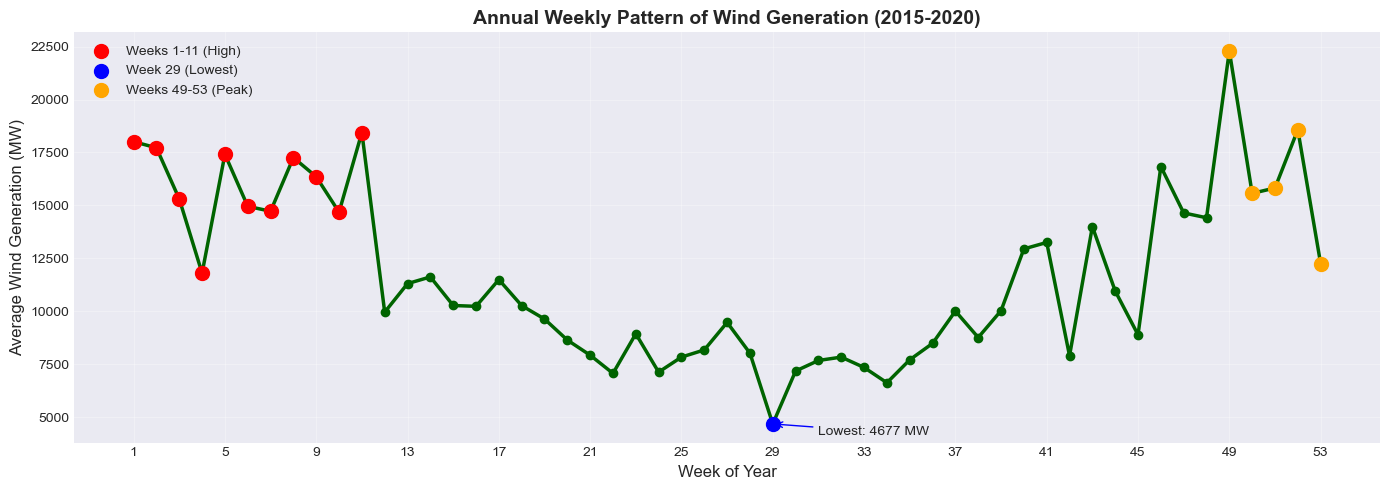

In [17]:
wind_df['week'] = wind_df.index.isocalendar().week
weekly_avg = wind_df.groupby('week')["DE_wind_generation_actual"].mean()

plt.figure(figsize=(14, 5))

plt.plot(weekly_avg.index, weekly_avg.values, 
         color='darkgreen', linewidth=2.5, marker='o', markersize=6)

# Highlight the specific weeks you observed
highlight_weeks = {'Weeks 1-11 (High)': range(1, 12), 'Week 29 (Lowest)': [29], 'Weeks 49-53 (Peak)': range(49, 54)}

colors = {'Weeks 1-11 (High)': 'red', 'Week 29 (Lowest)': 'blue', 'Weeks 49-53 (Peak)': 'orange'}

for label, weeks in highlight_weeks.items():
    for week in weeks:
        if week in weekly_avg.index:
            plt.scatter(week, weekly_avg[week], 
                       color=colors[label], s=100, zorder=5, label=label)
            # Add text annotation for key weeks
            if week == 29:
                plt.annotate(f'Lowest: {weekly_avg[week]:.0f} MW', 
                            xy=(week, weekly_avg[week]),
                            xytext=(week+2, weekly_avg[week]-500),
                            arrowprops=dict(arrowstyle='->', color='blue'),
                            fontsize=10)

# Customize x-axis (show every 4 weeks for clarity)
plt.xticks(range(1, 54, 4))
plt.xlabel("Week of Year", fontsize=12)
plt.ylabel("Average Wind Generation (MW)", fontsize=12)
plt.title("Annual Weekly Pattern of Wind Generation (2015-2020)", 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Handle duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
print("\n" + "=" * 60)
print("WEEKLY PATTERN VALIDATION")
print("=" * 60)
print(f"• Weeks 1-11 Avg: {weekly_avg.loc[1:11].mean():.0f} MW")
print(f"• Week 29 Value: {weekly_avg.loc[29]:.0f} MW (Lowest)")
print(f"• Weeks 49-53 Avg: {weekly_avg.loc[49:53].mean():.0f} MW")
print(f"\nThe clear annual cycle shows why SARIMA with yearly seasonality")
print(f"(or Fourier terms) is appropriate for this dataset.")


WEEKLY PATTERN VALIDATION
• Weeks 1-11 Avg: 16060 MW
• Week 29 Value: 4677 MW (Lowest)
• Weeks 49-53 Avg: 16901 MW

The clear annual cycle shows why SARIMA with yearly seasonality
(or Fourier terms) is appropriate for this dataset.


# Time series decomposition

## 1. Global view

<Figure size 1400x500 with 0 Axes>

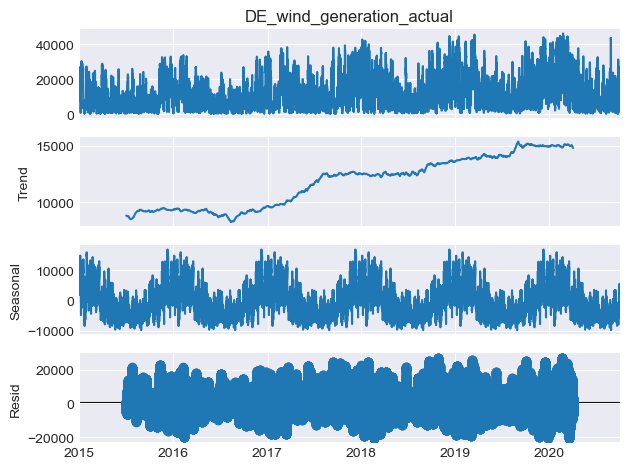

In [19]:
series = wind_df["DE_wind_generation_actual"]

# Seasonal decomposition
# model='additive': assume additive relationship between trend, seasonal, and residual
# period=96*365: there are 96 data points per day (15-minute intervals), 
# so 96*365 corresponds to a one-year seasonal cycle
result = seasonal_decompose(series, model='additive', period=96*365)  

plt.figure(figsize=(14,5))
result.plot()
plt.show()

## 2. Daily and weekly profile

In [20]:
print("=" * 70)
print("TIME SERIES DECOMPOSITION STRATEGY")
print("=" * 70)
print("Step 1: Analyze LONG-TERM trends and ANNUAL seasonality using DAILY data")
print("Step 2: Analyze INTRADAY patterns using SHORT periods")
print("=" * 70)

TIME SERIES DECOMPOSITION STRATEGY
Step 1: Analyze LONG-TERM trends and ANNUAL seasonality using DAILY data
Step 2: Analyze INTRADAY patterns using SHORT periods


In [21]:
# ------------------------------------------------------------
# STEP 1: LONG-TERM DECOMPOSITION (Daily Data)
# ------------------------------------------------------------
print("\n1. RESAMPLING to DAILY frequency for trend/seasonality analysis...")
daily_series = wind_df["DE_wind_generation_actual"].resample('D').mean()

print(f"   • Original shape (15-min): {wind_df.shape}")
print(f"   • Resampled shape (daily): {daily_series.shape}")
print(f"   • Period for decomposition: 365 days (annual cycle)")

# Perform decomposition on daily data
print("\n2. Performing seasonal decomposition ")
result_daily = seasonal_decompose(daily_series, model='additive', period=365)


1. RESAMPLING to DAILY frequency for trend/seasonality analysis...
   • Original shape (15-min): (201604, 5)
   • Resampled shape (daily): (2101,)
   • Period for decomposition: 365 days (annual cycle)

2. Performing seasonal decomposition 


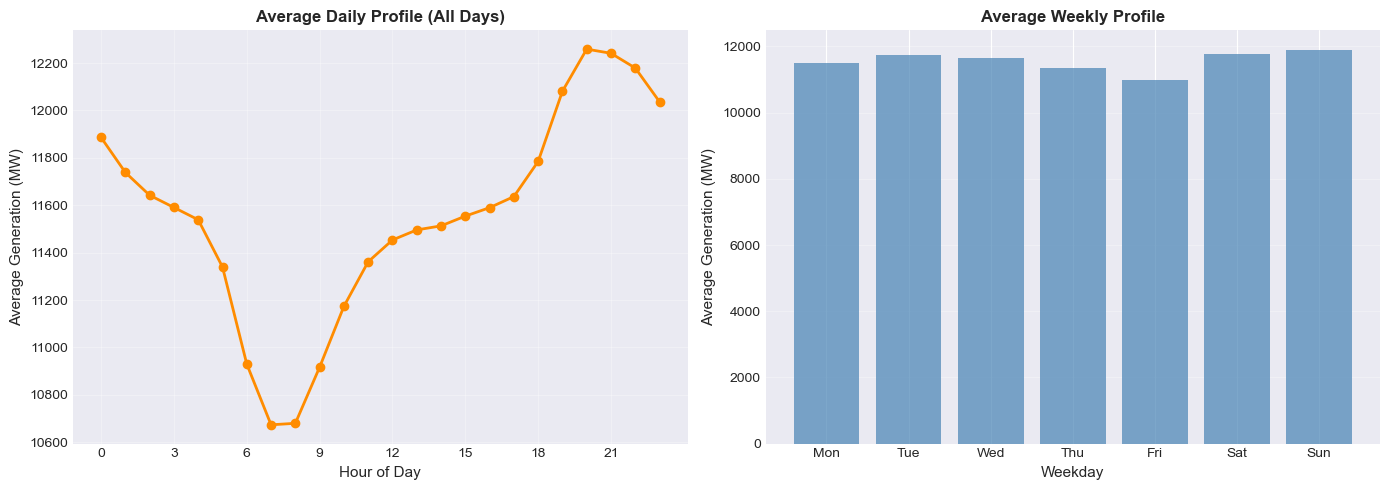

In [22]:
# Analyze typical daily profile (average generation by hour)
wind_df['hour'] = wind_df.index.hour
hourly_profile = wind_df.groupby('hour')['DE_wind_generation_actual'].mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Daily profile
ax[0].plot(hourly_profile.index, hourly_profile.values, 
           marker='o', color='darkorange', linewidth=2)
ax[0].set_xlabel('Hour of Day', fontsize=11)
ax[0].set_ylabel('Average Generation (MW)', fontsize=11)
ax[0].set_title('Average Daily Profile (All Days)', fontsize=12, fontweight='bold')
ax[0].grid(True, alpha=0.3)
ax[0].set_xticks(range(0, 24, 3))

# Weekly profile (by weekday)
wind_df['weekday'] = wind_df.index.weekday
weekday_profile = wind_df.groupby('weekday')['DE_wind_generation_actual'].mean()

weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax[1].bar(range(7), weekday_profile.values, color='steelblue', alpha=0.7)
ax[1].set_xlabel('Weekday', fontsize=11)
ax[1].set_ylabel('Average Generation (MW)', fontsize=11)
ax[1].set_title('Average Weekly Profile', fontsize=12, fontweight='bold')
ax[1].grid(True, alpha=0.3, axis='y')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(weekday_names)

plt.tight_layout()
plt.show()

In [23]:
print("\n" + "=" * 70)
print("DECOMPOSITION FINDINGS SUMMARY")
print("=" * 70)

# Check residual statistics (should be close to white noise)
resid_mean = result_daily.resid.mean()
resid_std = result_daily.resid.std()

print(f"\n1. RESIDUAL ANALYSIS:")
print(f"   • Mean of residuals: {resid_mean:.2f} MW (should be ~0)")
print(f"   • Std of residuals: {resid_std:.2f} MW")
print(f"   • 95% of residuals between: [{resid_mean-2*resid_std:.0f}, {resid_mean+2*resid_std:.0f}] MW")

print(f"\n2. SEASONAL STRENGTH:")
seasonal_amplitude = result_daily.seasonal.max() - result_daily.seasonal.min()
print(f"   • Annual seasonal amplitude: {seasonal_amplitude:.0f} MW")
print(f"   • Relative to trend: {(seasonal_amplitude/daily_series.mean()*100):.1f}% of mean")

print(f"\n3. MODELING IMPLICATIONS:")
print(f"   • Clear ANNUAL seasonality present → SARIMA needs yearly cycle (m=365 or Fourier)")
print(f"   • Strong WEEKLY pattern visible → Consider m=7 or weekday dummy variables")
print(f"   • Relatively stable trend → Differencing (d=1) likely sufficient")

print("\n" + "=" * 70)


DECOMPOSITION FINDINGS SUMMARY

1. RESIDUAL ANALYSIS:
   • Mean of residuals: 180.66 MW (should be ~0)
   • Std of residuals: 6492.78 MW
   • 95% of residuals between: [-12805, 13166] MW

2. SEASONAL STRENGTH:
   • Annual seasonal amplitude: 23522 MW
   • Relative to trend: 203.6% of mean

3. MODELING IMPLICATIONS:
   • Clear ANNUAL seasonality present → SARIMA needs yearly cycle (m=365 or Fourier)
   • Strong WEEKLY pattern visible → Consider m=7 or weekday dummy variables
   • Relatively stable trend → Differencing (d=1) likely sufficient



# Long-Short-Term-Memory (LSTM) model

## Step 1: Training-test-data split 

In [24]:
random.seed(42)

In [25]:
wind_df.head()

,DE_wind_generation_actual,month,hour,weekday,week
timestamp,,,,,
2014-12-31 23:00:00+00:00,8818.5,12,23,2,1
2014-12-31 23:15:00+00:00,8818.5,12,23,2,1
2014-12-31 23:30:00+00:00,8818.5,12,23,2,1
2014-12-31 23:45:00+00:00,8818.5,12,23,2,1
2015-01-01 00:00:00+00:00,8818.5,1,0,3,1


In [26]:
wind_df = wind_df[wind_df.index >= "2015-01-01"]

In [27]:
daily_df = wind_df[['DE_wind_generation_actual']].resample('D').mean()

train = daily_df[daily_df.index < "2019-01-01"]
test  = daily_df[daily_df.index >= "2019-01-01"]

## Step 2: Scale the data

In [28]:
# Normalize the wind generation data to the range [0, 1] using MinMaxScaler
# This helps the LSTM model converge faster and improves training stability

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))  
test_scaled  = scaler.transform(test.values.reshape(-1,1))   

## Step 3: Create sequential data

In [29]:
# Transform the time series into input-output sequences for LSTM
# X: previous timesteps used as features
# y: target value at the next timestep
# This step allows the LSTM to learn temporal dependencies

def create_sequences(data, timesteps=30):
    """
    data: np.array, shape = (num_samples, num_features)
    target_col: DE_wind_generation_actual
    timesteps: 96*7
    """
    X, y = [], []
    for i in range(len(data)-timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps, 0])  # forecasting only for DE_wind_generation_actual
    return np.array(X), np.array(y)

# timesteps: Using 3 days of historical data to predict the next time step
X_train, y_train = create_sequences(train_scaled, timesteps=30)
X_test, y_test   = create_sequences(test_scaled, timesteps=30)

print("X_train:", X_train.shape)  # (samples, timesteps, 1)
print("y_train:", y_train.shape)  # (samples,)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1431, 30, 1)
y_train: (1431,)
X_test: (609, 30, 1)
y_test: (609,)


## Step 4: Train the LSTM model¶

In [30]:
# Fit the LSTM model on the sequential data
# Use previous timesteps as input (X) and next timestep as target (y)
# Train for a specified number of epochs to minimize the loss
# Monitor training loss to ensure proper convergence

lstm_model = Sequential()

# Layer 1: LSTM with return_sequences=True to feed to next LSTM layer
lstm_model.add(LSTM(
    units=100, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh',  
    return_sequences=True,  # Important for stacked LSTM
    recurrent_dropout=0.1,  # Prevent overfitting in recurrent connections
    kernel_initializer='glorot_uniform'))

# Layer 2: Second LSTM layer (deeper model can capture more complex patterns)
lstm_model.add(LSTM(units=50, activation='tanh', return_sequences=False,  recurrent_dropout=0.1))
              # Last LSTM layer, don't return sequences

# Dropout to prevent overfitting
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(1, activation='linear'))  # Linear activation for regression

C:\Users\vogel\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
# Use lower learning rate for more stable training
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)  # Gradient clipping for stability

lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 

In [32]:
# Model summary
print("\nModel Architecture:")
lstm_model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Wait 10 epochs after last improvement
        restore_best_weights=True,  # Keep the best model weights
        verbose=1
    ),
    
    # Reduce learning rate when learning stagnates
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half
        patience=5,  # Wait 5 epochs
        min_lr=1e-6,  # Minimum learning rate
        verbose=1),
    # Save the best model (optional)
    # ModelCheckpoint(
    #     'best_lstm_model.h5',
    #     monitor='val_loss',
    #     save_best_only=True,
    #     verbose=0
    # )
]

In [34]:
print(f"\nCallbacks configured:")
print(f"  • EarlyStopping: Stops if no improvement in val_loss for 10 epochs")
print(f"  • ReduceLROnPlateau: Reduces LR if learning stagnates")


Callbacks configured:
  • EarlyStopping: Stops if no improvement in val_loss for 10 epochs
  • ReduceLROnPlateau: Reduces LR if learning stagnates


In [35]:
history = lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,  
    validation_data=(X_test, y_test),
    verbose=1,  # Show progress bar
    callbacks=callbacks,
    shuffle=False  # IMPORTANT: Don't shuffle time series data!
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - loss: 0.0308 - mae: 0.1353 - val_loss: 0.0401 - val_mae: 0.1530 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0281 - mae: 0.1308 - val_loss: 0.0388 - val_mae: 0.1495 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0263 - mae: 0.1263 - val_loss: 0.0360 - val_mae: 0.1458 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0251 - mae: 0.1229 - val_loss: 0.0340 - val_mae: 0.1417 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0234 - mae: 0.1193 - val_loss: 0.0323 - val_mae: 0.1389 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0225 - mae: 0.1167 - val_loss: 0.0302 - val_mae: 0.1346 - learning_rate: 0.0010
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0214 - mae: 0.1126 - val_loss: 0.0283 - val_mae: 0.1311 - learning_rate: 0.0010
Epoch 8/10


In [36]:
# TRAINING HISTORY ANALYSIS
# ------------------------------------------------------------
print("\n" + "=" * 70)
print("TRAINING RESULTS SUMMARY")
print("=" * 70)

final_epoch = len(history.history['loss'])
print(f"Actual epochs trained: {final_epoch} (early stopped at epoch {final_epoch})")

# Get best validation loss
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")

# Check for overfitting
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
overfit_ratio = final_val_loss / final_train_loss

if overfit_ratio > 1.5:
    print(f"Potential overfitting: val_loss ({final_val_loss:.4f}) > 1.5× train_loss ({final_train_loss:.4f})")
    print(f" Consider increasing dropout or reducing model complexity")
else:
    print(f" Good generalization: val_loss ({final_val_loss:.4f}) close to train_loss ({final_train_loss:.4f})")


TRAINING RESULTS SUMMARY
Actual epochs trained: 10 (early stopped at epoch 10)
Best validation loss: 0.025698 at epoch 10
 Good generalization: val_loss (0.0257) close to train_loss (0.0186)


## Step 5: Forecasting

In [37]:
# 1. Make predictions
print("Generating predictions on test set")
y_pred_scaled = lstm_model.predict(X_test, verbose=0)

# 2. Inverse transform (SIMPLE VERSION - for univariate series)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

Generating predictions on test set


In [38]:
# 4. Calculate basic statistics
# ------------------------------------------------------------
print("\n" + "=" * 70)
print("PREDICTION STATISTICS")
print("=" * 70)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
print(f"Predictions range: [{y_pred.min():.0f}, {y_pred.max():.0f}] MW")
print(f"Actual range: [{y_test_inv.min():.0f}, {y_test_inv.max():.0f}] MW")
print(f"Mean prediction: {y_pred.mean():.0f} MW")
print(f"Mean actual: {np.mean(test):.0f} MW")


PREDICTION STATISTICS
Predictions range: [4884, 36984] MW
Actual range: [1074, 43087] MW
Mean prediction: 13353 MW
Mean actual: 14152 MW


## Step 6: Evaluate the results

In [39]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae  = mean_absolute_error(y_test_inv, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 6561.91, MAE: 5066.57


## Step 7: Visualize the forecasting results¶

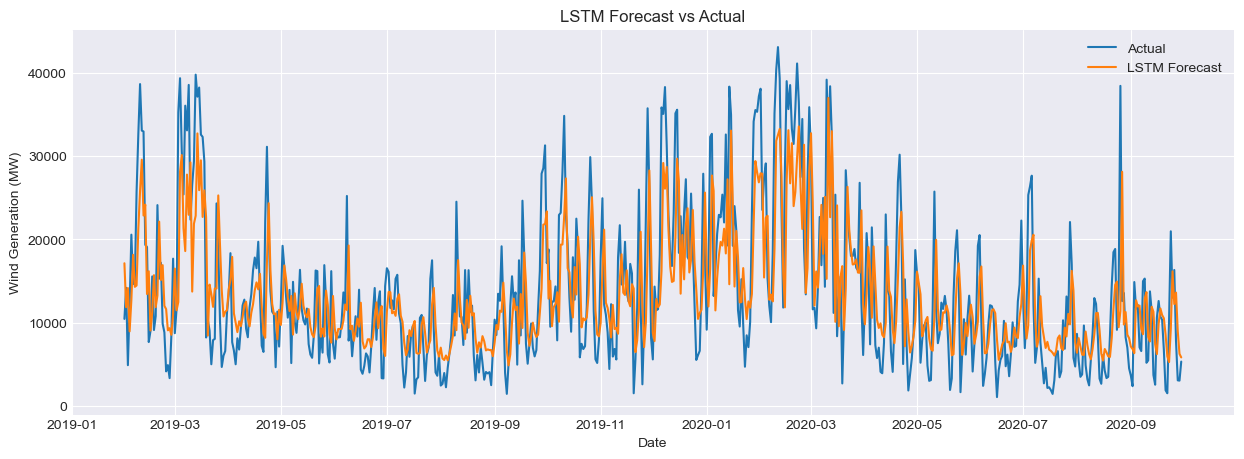

In [40]:
# Plot the predicted wind generation against the actual values
# This helps us evaluate the model's performance and identify patterns the LSTM has learned
# y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(15,5))
plt.plot(test.index[30:], y_test_inv, label="Actual")
plt.plot(test.index[30:], y_pred, label="LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Wind Generation (MW)")
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.show()

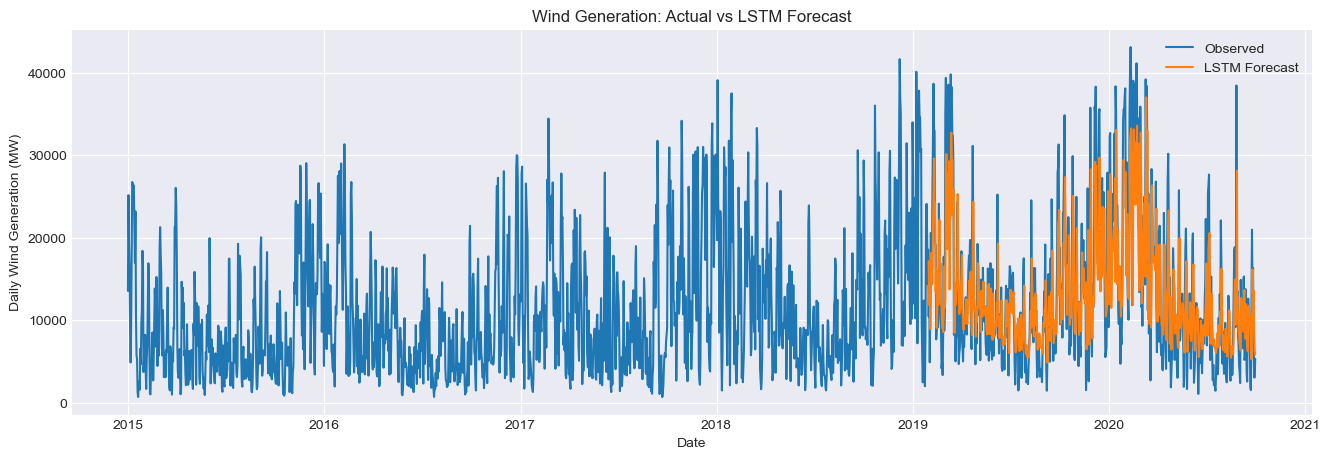

In [41]:
plt.figure(figsize=(16,5))
plt.plot(daily_df.index, daily_df.DE_wind_generation_actual, label='Observed')
plt.plot(test.index[30:], y_pred, label='LSTM Forecast')  
plt.xlabel('Date')
plt.ylabel('Daily Wind Generation (MW)')
plt.title('Wind Generation: Actual vs LSTM Forecast')
plt.legend()
plt.show()

In [42]:
lstm_model.save("lstm_wind_forecast_model.keras")

In [43]:
# from tensorflow.keras.models import load_model
# model = load_model("lstm_wind_forecast_model.keras")

# SARIMA model

In [44]:
print("=" * 70)
print("SARIMA MODEL - QUICK DEMO")
print("=" * 70)
print("Using same train/test split as LSTM for fair comparison")
print(f"Train: {train.index[0].date()} to {train.index[-1].date()} ({len(train)} days)")
print(f"Test:  {test.index[0].date()} to {test.index[-1].date()} ({len(test)} days)")
print("=" * 70)

SARIMA MODEL - QUICK DEMO
Using same train/test split as LSTM for fair comparison
Train: 2015-01-01 to 2018-12-31 (1461 days)
Test:  2019-01-01 to 2020-09-30 (639 days)


## Part 1: Data Preparation and Stationarity Check

### Step 1: Resample the data

In [45]:
train_sarima = daily_df[(daily_df.index >= "2018-01-01") & (daily_df.index < "2020-06-01")]
test_sarima  = daily_df[daily_df.index >= "2020-06-01"]

In [46]:
scaler_sarima = StandardScaler()
train_scaled = scaler_sarima.fit_transform(train_sarima.values.reshape(-1, 1))
train_scaled_series = pd.Series(train_scaled.flatten(), index=train_sarima.index)

### Step 2: Stationarity testing 

In [47]:
adf_result = adfuller(train_sarima)
print(f"   ADF Statistic: {adf_result[0]:.3f}")
print(f"   p-value: {adf_result[1]:.3f}")

   ADF Statistic: -5.110
   p-value: 0.000


### Step 3: Seasonality detection (ACF/PACF)


 Checking seasonality with ACF/PACF plots


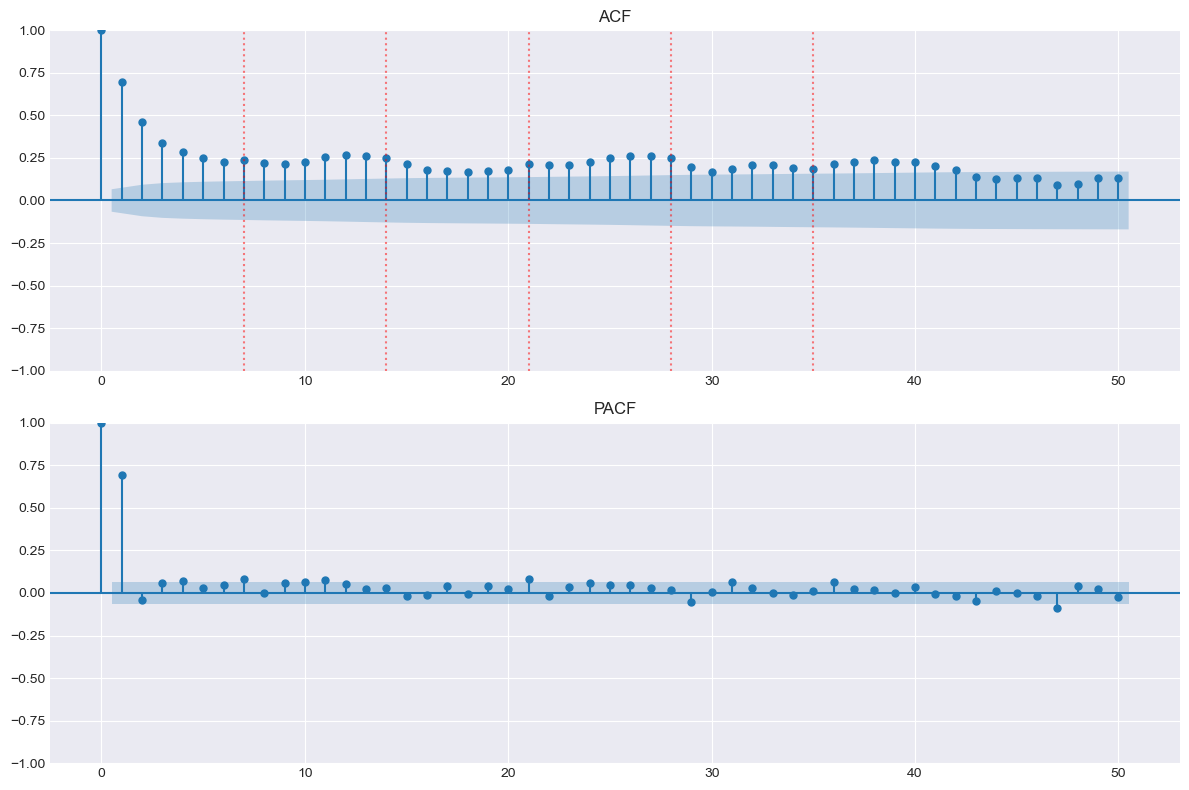

In [48]:
# Check for weekly patterns (ACF) and AR order (PACF)
print("\n Checking seasonality with ACF/PACF plots")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot - look for weekly pattern
plot_acf(train_sarima, lags=50, ax=ax1, title='ACF')
# Mark weekly lags
for week in [7, 14, 21, 28, 35]: ax1.axvline(x=week, color='red', linestyle=':', alpha=0.5)

# PACF plot - decide AR order  
plot_pacf(train_sarima, lags=50, ax=ax2, title='PACF')

plt.tight_layout()
plt.show()

## Part 2: Model identification

In [49]:
y_train = train_sarima.squeeze()
y_test  = test_sarima.squeeze()

In [50]:
models = {
    "M1_AR2_SAR1": ((2,0,0), (1,0,0,7)),
    "M2_AR2_SMA1": ((2,0,0), (0,0,1,7)),
    "M3_AR2_SAR1_SMA1": ((2,0,0), (1,0,1,7)),
    "M4_AR1_SAR1_SMA1": ((1,1,0), (1,1,1,7)),
    "M5_AR1_SAR1_SMA1": ((2,1,0), (1,1,1,7)),
}

## Part 3: Candidate model estimation and selection

In [51]:
results_summary = []

for name, (order, seasonal_order) in models.items():
    print(f"\nFitting {name} {order}{seasonal_order}")
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)

    # ---- Train info ----
    aic = res.aic
    bic = res.bic

    # ---- Test forecast ----
    forecast = res.get_forecast(steps=len(test_sarima))
    y_pred = forecast.predicted_mean
    y_true = test_sarima.squeeze()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)

    results_summary.append({"model": name, "order": order, "seasonal_order": seasonal_order,
        "AIC": aic, "BIC": bic, "RMSE": rmse, "MAE": mae})


Fitting M1_AR2_SAR1 (2, 0, 0)(1, 0, 0, 7)

Fitting M2_AR2_SMA1 (2, 0, 0)(0, 0, 1, 7)

Fitting M3_AR2_SAR1_SMA1 (2, 0, 0)(1, 0, 1, 7)

Fitting M4_AR1_SAR1_SMA1 (1, 1, 0)(1, 1, 1, 7)

Fitting M5_AR1_SAR1_SMA1 (2, 1, 0)(1, 1, 1, 7)


In [52]:
results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values("RMSE")

In [53]:
print(results_df)

              model      order seasonal_order           AIC           BIC  \
2  M3_AR2_SAR1_SMA1  (2, 0, 0)   (1, 0, 1, 7)  17895.884656  17919.744334   
3  M4_AR1_SAR1_SMA1  (1, 1, 0)   (1, 1, 1, 7)  18027.353134  18046.408673   
4  M5_AR1_SAR1_SMA1  (2, 1, 0)   (1, 1, 1, 7)  17972.874908  17996.688555   
1       M2_AR2_SMA1  (2, 0, 0)   (0, 0, 1, 7)  17971.063497  17990.155818   
0       M1_AR2_SAR1  (2, 0, 0)   (1, 0, 0, 7)  17950.872139  17969.959881   

           RMSE          MAE  
2   6628.274677  4940.161191  
3   7125.171379  5183.801493  
4   7607.603463  5375.992200  
1  10363.942028  8247.141334  
0  10376.871420  8261.246457  


## Part 4: Final model evaluation

In [54]:
sarima_final = SARIMAX(
    y_train,
    order=(2,0,0),          # without seasonality AR(2)
    seasonal_order=(1,0,1,7),  # with seasonality AR(1)+MA(1), s=7
    enforce_stationarity=False,
    enforce_invertibility=False)

In [55]:
results_final = sarima_final.fit(disp=False)

In [56]:
print(results_final.summary())

                                      SARIMAX Results                                      
Dep. Variable:           DE_wind_generation_actual   No. Observations:                  882
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -8942.942
Date:                             Wed, 04 Feb 2026   AIC                          17895.885
Time:                                     10:46:49   BIC                          17919.744
Sample:                                 01-01-2018   HQIC                         17905.013
                                      - 05-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7106      0.035     20.264      0.000       0.642       0.779
ar.L2         -0.0755      

## Part 5: Model forecasting

In [57]:
forecast = results_final.get_forecast(steps=len(y_test))
y_pred = forecast.predicted_mean
y_pred_ci = forecast.conf_int()

In [58]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 6628.27, MAE: 4940.16


## Part 6: Forecast visualization

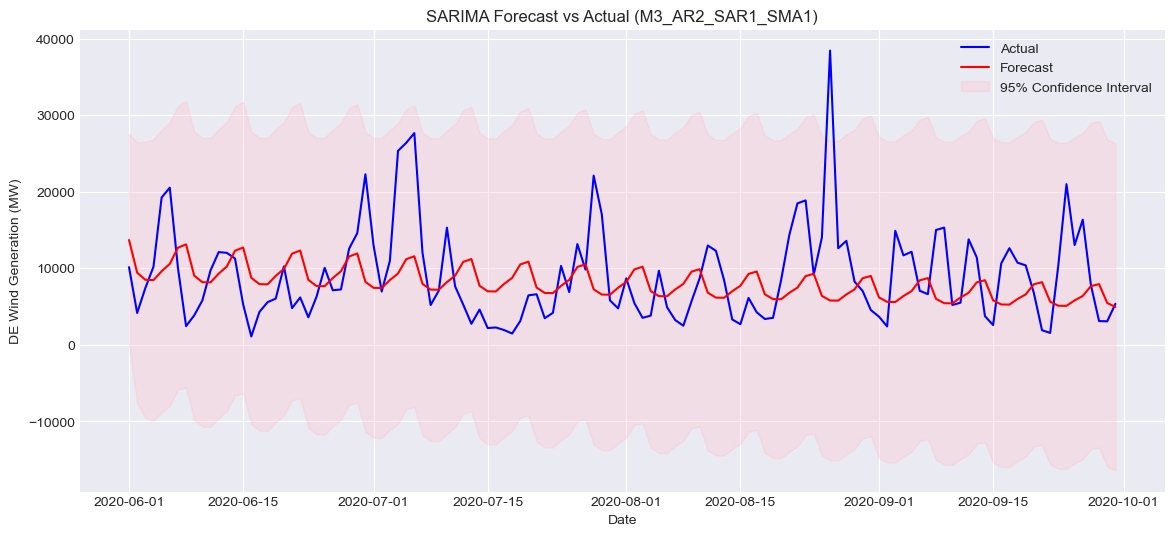

In [59]:
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Forecast', color='red')
plt.fill_between(
    y_test.index,
    y_pred_ci.iloc[:,0],
    y_pred_ci.iloc[:,1],
    color='pink', alpha=0.3,
    label='95% Confidence Interval'
)
plt.title("SARIMA Forecast vs Actual (M3_AR2_SAR1_SMA1)")
plt.xlabel("Date")
plt.ylabel("DE Wind Generation (MW)")
plt.legend()
plt.show()

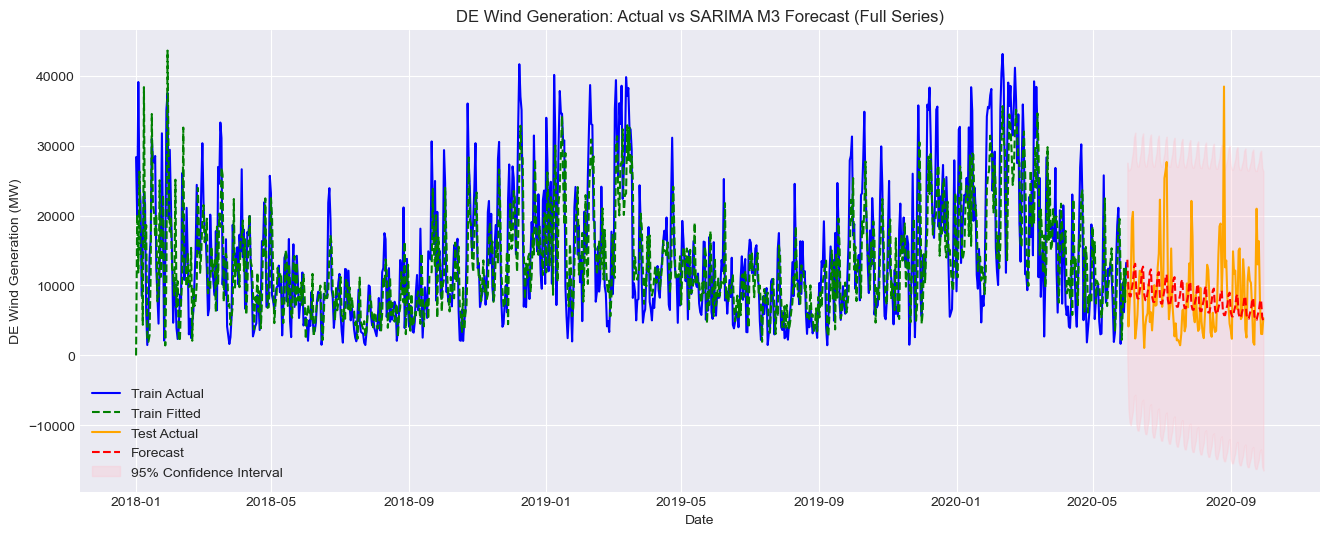

In [60]:
# -------------------------
# 1️. Get in-sample fitted values for the training set
# -------------------------
in_sample_pred = results_final.get_prediction(start=y_train.index[0], end=y_train.index[-1])
in_sample_mean = in_sample_pred.predicted_mean

# Get out-of-sample forecast for the test set
forecast = results_final.get_forecast(steps=len(y_test))
out_sample_pred = forecast.predicted_mean
out_sample_ci = forecast.conf_int()

# -------------------------
# 2. Plot the full series: training + test actuals and predictions
# -------------------------
plt.figure(figsize=(16,6))

# Plot actual values of the training set
plt.plot(y_train.index, y_train, label='Train Actual', color='blue')

# Plot in-sample fitted values (training set)
plt.plot(y_train.index, in_sample_mean, label='Train Fitted', color='green', linestyle='--')

# Plot actual values of the test set
plt.plot(y_test.index, y_test, label='Test Actual', color='orange')

# Plot out-of-sample forecast (test set)
plt.plot(y_test.index, out_sample_pred, label='Forecast', color='red', linestyle='--')

# Add 95% confidence interval for the forecast
plt.fill_between(y_test.index, out_sample_ci.iloc[:,0], out_sample_ci.iloc[:,1], 
                 color='pink', alpha=0.3,label='95% Confidence Interval')

# Add title, axis labels and legend
plt.title("DE Wind Generation: Actual vs SARIMA M3 Forecast (Full Series)")
plt.xlabel("Date")
plt.ylabel("DE Wind Generation (MW)")
plt.legend()
plt.show()

## Part 7: Residual diagnostics

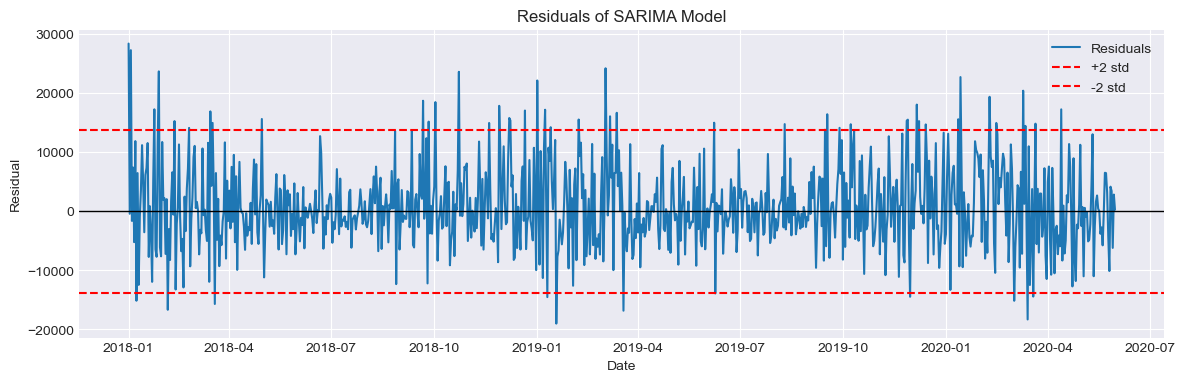

In [61]:
residuals = results_final.resid
std = residuals.std()

plt.figure(figsize=(14,4))
plt.plot(residuals, label="Residuals")
plt.axhline(2*std, linestyle="--", color="red", label="+2 std")
plt.axhline(-2*std, linestyle="--", color="red", label="-2 std")
plt.axhline(0, color="black", linewidth=1)

plt.title("Residuals of SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

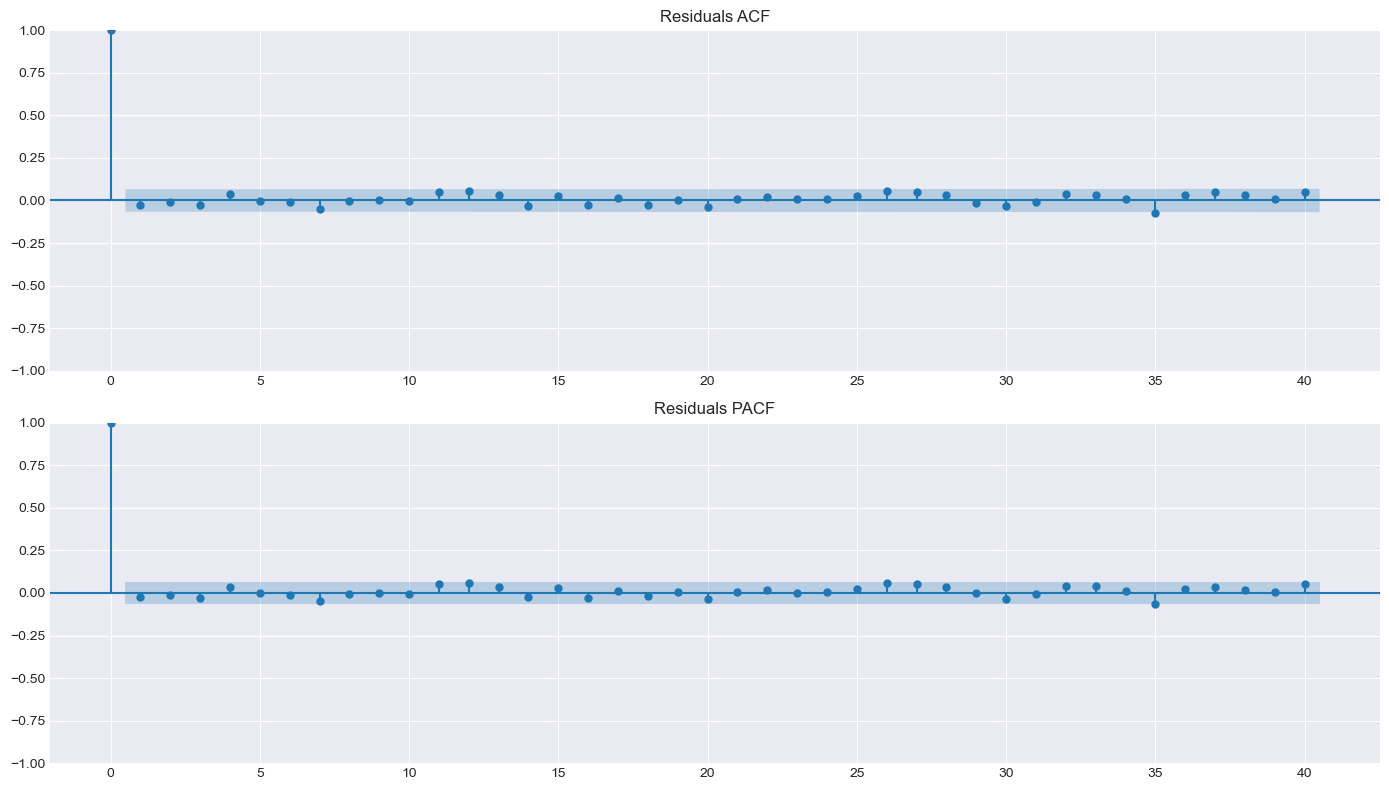

In [62]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,8))
plot_acf(residuals, lags=40, ax=ax1, title='Residuals ACF')
plot_pacf(residuals, lags=40, ax=ax2, title='Residuals PACF')
plt.tight_layout()
plt.show()

In [63]:
# save scaler 
joblib.dump(scaler, "wind_scaler.pkl")

['wind_scaler.pkl']